In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')

In [2]:
pinfo = pd.read_csv('../../masked/patients_info.csv', index_col=0)
pinfo['Molecular_Subtype'] = pinfo['HER2_Status']+pinfo['ER_Status']

In [3]:
meth = pd.read_csv('../../masked/meth.csv', index_col=0)
rna = (pd.read_csv('../../masked/rna.csv', index_col=0)+0.01).applymap(np.log2)
dia = pd.read_csv('../../masked/dia.csv', index_col=0)

In [4]:
pinfo['CDKN2A_meth'] = pinfo.index.map(meth['NM_001195132'])
pinfo['CDKN2A_dia'] = pinfo.index.map(dia['CDKN2A'])
pinfo['CDKN2A_rna'] = pinfo.index.map(rna['CDKN2A'])

In [5]:
pinfo['CDKN2A_cn'] = pinfo.index.map({\
                                      'PS006':-1,\
                                      'PS008':-1,\
                                      'PS016':-1,\
                                      'PS029':-1,\
                                      'PS052':-1,\
                                      'PS064':-1,\
                                      'PS118':-1,\
                                      'PS013':1,\
                                     }).fillna(0)

RanksumsResult(statistic=-3.6408156859939185, pvalue=0.0002717756495986)
NegNeg_0 v.s. NegNeg_1: Mann-Whitney-Wilcoxon test two-sided, P_val=4.043e-03 U_stat=4.430e+02
PosNeg_0 v.s. PosNeg_1: Mann-Whitney-Wilcoxon test two-sided, P_val=4.255e-01 U_stat=1.220e+02
PosPos_0 v.s. PosPos_1: Mann-Whitney-Wilcoxon test two-sided, P_val=5.788e-01 U_stat=3.950e+02


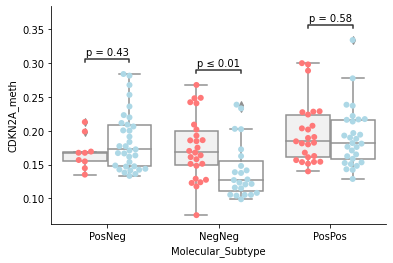

In [6]:
import seaborn as sns
from statannot import add_stat_annotation
from itertools import combinations

print(st.ranksums(pinfo[pinfo['Molecular_Subtype']=='NegNeg']['CDKN2A_meth'].dropna(),\
                  pinfo[pinfo['Molecular_Subtype']!='NegNeg']['CDKN2A_meth'].dropna()))

def swarmplot_anno(x=None, y=None, hue=None, data=None, order=None, hue_order=None,\
                   dodge=False, orient=None, color=None, palette=None, size=5,\
                   edgecolor='gray', linewidth=0, ax=None, cmp_x=True, **kwargs):
    
    ax = sns.swarmplot(x=x, y=y, hue=hue, data=data, order=order, hue_order=hue_order,\
                       dodge=dodge, orient=orient, color=color, palette=palette, size=size,\
                       edgecolor=edgecolor, linewidth=linewidth, ax=ax, **kwargs)
    ax = sns.boxplot(x=x, y=y, hue=hue, color='white')

    add_stat_annotation(ax, x=x, y=y, hue=hue,
                        box_pairs=(((i, k) for k in j) for j in combinations(hue.dropna().unique(),2) for i in x.dropna().unique()),
                        test='Mann-Whitney', text_format='simple', loc='inside', \
                        comparisons_correction=None , verbose=2)
    if cmp_x:
        add_stat_annotation(ax, x=x, y=y,
                            box_pairs=(i for i in combinations(x.dropna().unique(),2)),
                            test='Mann-Whitney', text_format='simple', loc='outside', \
                            comparisons_correction=None , verbose=2)
    
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.get_legend().remove()

swarmplot_anno(pinfo['Molecular_Subtype'],pinfo['CDKN2A_meth'],pinfo['pCR'],dodge=1, \
               palette={0:'#ff7878',1:'lightblue'}, s=6, cmp_x=0)

In [7]:
import scipy.stats as st

tnbc = pinfo[pinfo['Molecular_Subtype']=='NegNeg'].dropna(subset=['CDKN2A_meth'])
st.spearmanr(tnbc['CDKN2A_meth'],tnbc['CDKN2A_rna'], nan_policy='omit'),\
st.spearmanr(tnbc['CDKN2A_meth'],tnbc['CDKN2A_dia'], nan_policy='omit')

(SpearmanrResult(correlation=-0.5800185013876041, pvalue=1.9291876029400207e-05),
 SpearmanrResult(correlation=-0.5001698950217767, pvalue=0.0006369932839922195))

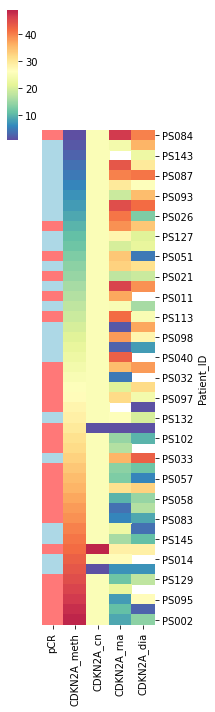

In [8]:
import matplotlib.pyplot as plt
sns.clustermap(tnbc.sort_values(['CDKN2A_meth'])\
            [['CDKN2A_meth','CDKN2A_cn','CDKN2A_rna','CDKN2A_dia']].rank(),\
            row_colors=tnbc.sort_values(['CDKN2A_meth'])\
            ['pCR'].map({0:'#ff7878',1:'lightblue'}), \
            cmap='Spectral_r', center=26.5, colors_ratio=0.15,\
               row_cluster=0, col_cluster=0, figsize=[3,10])#'pCR',

In [9]:
import gseapy as gp
gene_sets="/Users/zzhuay/GSEA_4.1.0/ref/msigdb.hallmark.gmt"

In [10]:
sprs = []
spps = []

tpm5 = rna.copy()
tpm5['methyl'] = tpm5.index.map(tnbc['CDKN2A_meth'])

for i in rna.columns:
    sptest = st.spearmanr(-1*tpm5['methyl'], tpm5[i], nan_policy='omit')
    sprs.append(sptest.correlation)
    spps.append(sptest.pvalue)
    
demethyl = pd.DataFrame(sprs, rna.columns)
demethyl['p'] = spps
demethyl = demethyl.sort_values(0).dropna()

pre_res_rna = gp.prerank(rnk=demethyl[demethyl['p']<0.05][[0]], gene_sets=gene_sets,\
                     min_size=0,max_size=201,seed=1,
                     outdir='../figures/CDKN2A_rna', format='pdf')

In [11]:
pre_res_rna.res2d.dropna().sort_values('nes')[-3:]

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
HALLMARK_MYC_TARGETS_V1,0.794013,7.298960,0.0,0.0,200,59,TFDP1;VBP1;USP1;MCM2;DEK;RRM1;SNRPD1;VDAC3;MCM...,TFDP1;VBP1;USP1;MCM2;DEK;RRM1;SNRPD1;VDAC3;MCM...
HALLMARK_G2M_CHECKPOINT,0.697057,7.775894,0.0,0.0,200,94,TFDP1;KIF4A;DKC1;MKI67;MCM2;CDK1;KIF11;TTK;SNR...,TFDP1;KIF4A;DKC1;MKI67;MCM2;CDK1;KIF11;TTK;SNR...
HALLMARK_E2F_TARGETS,0.786290,9.834817,0.0,0.0,200,109,KIF4A;USP1;MKI67;CDKN2A;MCM2;CDCA8;CDK1;CCNE1;...,KIF4A;USP1;MKI67;CDKN2A;MCM2;CDCA8;CDK1;CCNE1;...


In [12]:
sprs = []
spps = []

dia5 = dia.copy()
dia5['methyl'] = dia5.index.map(tnbc['CDKN2A_meth'])

for i in dia.columns:
    sptest = st.spearmanr(-1*dia5['methyl'], dia5[i], nan_policy='omit')
    sprs.append(sptest.correlation)
    spps.append(sptest.pvalue)
    
ddmethyl = pd.DataFrame(sprs, dia.columns)
ddmethyl['p'] = spps
ddmethyl = ddmethyl.sort_values(0).dropna()

pre_res_dia = gp.prerank(rnk=ddmethyl[ddmethyl['p']<0.05][[0]], gene_sets=gene_sets,\
                     min_size=0,max_size=201,seed=1,graph_num=50,
                     outdir='../figures/CDKN2A_dia', format='pdf')

In [13]:
pre_res_dia.res2d.dropna().sort_values('nes')[-3:]

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
HALLMARK_DNA_REPAIR,0.713161,3.211946,0.0,0.404373,150,16,RFC3;RFC5;RFC4;PCNA;IMPDH2;POLR2H;NELFCD;ALYRE...,RFC3;RFC5;RFC4;PCNA;IMPDH2;POLR2H;NELFCD;ALYRE...
HALLMARK_MYC_TARGETS_V1,0.517341,3.258660,0.0,0.505467,200,35,MCM7;RFC4;MCM4;CDK2;PCNA;MCM5;MCM2;MCM6;SRPK1;...,MCM7;RFC4;MCM4;CDK2;PCNA;MCM5;MCM2;MCM6;SRPK1;...
HALLMARK_E2F_TARGETS,0.554156,3.646484,0.0,0.673955,200,39,RFC3;MCM7;TOP2A;CDK1;MCM4;MCM3;NASP;PCNA;CDKN2...,RFC3;MCM7;TOP2A;CDK1;MCM4;MCM3;NASP;PCNA;CDKN2...


In [14]:
sprs = []
spps = []

pp = pd.read_csv('../../masked/pp.csv', index_col=0)
pp5 = pp.copy()
pp5['methyl'] = pp5.index.map(tnbc['CDKN2A_meth'])

for i in pp.columns:
    sptest = st.spearmanr(-1*pp5['methyl'], pp5[i], nan_policy='omit')
    sprs.append(sptest.correlation)
    spps.append(sptest.pvalue)
    
dpmethyl = pd.DataFrame(sprs, pp.columns)
dpmethyl['p'] = spps
dpmethyl = dpmethyl.sort_values(0).dropna()

pre_res_pp = gp.prerank(rnk=dpmethyl[dpmethyl['p']<0.05][[0]], gene_sets=gene_sets,\
                     min_size=0,max_size=201,seed=1,
                     outdir='../figures/CDKN2A_pp', format='pdf')

In [15]:
pre_res_pp.res2d.dropna().sort_values('nes')[-3:]

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
HALLMARK_MYC_TARGETS_V1,0.652632,1.744023,0.023392,0.852816,200,5,MCM2;DDX21;CTPS1;DUT;CDK2,MCM2;DDX21;CTPS1;DUT;CDK2
HALLMARK_E2F_TARGETS,0.606383,1.771438,0.017208,0.887506,200,6,MCM2;CTPS1;DUT;TOP2A;MKI67;RFC1,MCM2;CTPS1;DUT;TOP2A;MKI67;RFC1
HALLMARK_G2M_CHECKPOINT,0.670213,1.960165,0.005769,0.923326,200,6,MCM2;TOP2A;CENPF;YTHDC1;CHAF1A;MKI67,MCM2;TOP2A;CENPF;YTHDC1;CHAF1A;MKI67


In [16]:
# chr9:21,967,752-21,995,324 GeneCards

mC = pd.DataFrame(range(21967752-2000,21995324+2000),range(21967752-2000,21995324+2000))[[]]
tC = pd.DataFrame(range(21967752-2000,21995324+2000),range(21967752-2000,21995324+2000))[[]]
rC = pd.DataFrame(range(21967752-2000,21995324+2000),range(21967752-2000,21995324+2000))[[]]

for i in pinfo.loc[(pinfo['Methylation']==1)&(pinfo['Molecular_Subtype']=='NegNeg')].index:
    tmp = pd.read_csv('../../masked/CDKN2A_CpGs/'+i+'.CDKN2A.CpG.csv', index_col='pos')
    tmp = tmp[tmp['total_C']>=10]
    mC[i] = mC.index.map(tmp['methy_C'])
    tC[i] = tC.index.map(tmp['total_C'])
    rC[i] = rC.index.map(tmp['methy_C']/tmp['total_C'])

In [17]:
with open('CDKN2A_seq.txt') as f:
    lines = f.readlines()
    
cdkn2a_seq = ''.join(lines[1:]).replace('\n','')

In [18]:
cdkn2a_seq_dict = {}
for i in mC.index:
    cdkn2a_seq_dict[i] = cdkn2a_seq[i-21965752-1:i-21965752+1]
test = pd.DataFrame({'mC':mC.T.sum(),'tC':tC.T.sum(),'base':mC.index.map(cdkn2a_seq_dict)})
test['ratio'] = test['mC']/test['tC']

In [19]:
# Trimmer dict
cdkn2a_seq_dict3 = {}
for i in mC.index:
    cdkn2a_seq_dict3[i] = cdkn2a_seq[i-21965752-1:i-21965752+2]

In [20]:
tnbc_pcr = sorted(set.intersection(set(meth.index), set(pinfo.loc[(pinfo['Molecular_Subtype']=='NegNeg')&(pinfo['pCR']==1)].index)))
tnbc_nonpcr = sorted(set.intersection(set(meth.index), set(pinfo.loc[(pinfo['Molecular_Subtype']=='NegNeg')&(pinfo['pCR']==0)].index)))

In [21]:
mC_CG = mC.loc[mC.index[mC.index.map(cdkn2a_seq_dict).str.contains('CG')]]
tC_CG = tC.loc[tC.index[tC.index.map(cdkn2a_seq_dict).str.contains('CG')]]

In [22]:
len('CGAGCCACCCACTTAAGGCGGTGCGGTAGCCTAGAGGAGCGGCAGACTTCTCTTTCCCCATCCCCCG')

67

In [23]:
# (tC_CG.index>=(21996128))&(tC_CG.index<(21996128+67)
print(cdkn2a_seq[21996128-21965752:21996128+67-21965752])
print(rC.loc[tC.index[tC.index.map(cdkn2a_seq_dict).str.contains('CG')]].loc[(tC_CG.index>=(21996128))&(tC_CG.index<(21996128+67))].index.map(cdkn2a_seq_dict3))
rC.loc[tC.index[tC.index.map(cdkn2a_seq_dict).str.contains('CG')]].loc[(tC_CG.index>=(21996128))&(tC_CG.index<(21996128+67))]

CGAGCCACCCACTTAAGGCGGTGCGGTAGCCTAGAGGAGCGGCAGACTTCTCTTTCCCCATCCCCCG
Index(['CGA', 'CGG', 'CGG', 'CGG', 'CGC'], dtype='object')


,PS002,PS004,PS008,PS009,PS011,PS013,PS014,PS021,PS026,PS029,...,PS126,PS127,PS128,PS129,PS132,PS143,PS145,PS146,PS148,PS149
21996129,0.500000,0.300000,0.800000,0.615385,NaN,0.535714,0.400000,0.500000,NaN,0.416667,...,0.250000,0.000000,0.125000,0.461538,NaN,0.428571,NaN,0.473684,NaN,0.400000
21996147,0.714286,0.500000,0.857143,0.545455,0.100000,0.827586,NaN,0.750000,NaN,0.272727,...,0.083333,0.363636,0.263158,0.909091,NaN,0.277778,1.000000,0.375000,NaN,0.428571
21996152,0.733333,0.300000,0.928571,0.500000,0.000000,0.680000,NaN,0.521739,NaN,0.090909,...,0.250000,NaN,0.222222,0.800000,NaN,0.062500,NaN,0.266667,NaN,0.384615
21996168,0.642857,0.272727,0.647059,0.538462,0.083333,0.448276,0.727273,0.454545,0.187500,NaN,...,0.153846,0.100000,0.368421,0.600000,NaN,0.150000,0.333333,0.312500,NaN,0.333333
21996194,0.812500,0.727273,1.000000,0.642857,0.466667,0.666667,0.692308,0.954545,0.722222,NaN,...,0.307692,NaN,0.541667,NaN,NaN,0.409091,0.642857,0.733333,NaN,0.600000


In [24]:
# (tC_CG.index>=(21996128))&(tC_CG.index<(21996128+67)
print(cdkn2a_seq[21996128-21965752:21996128+67-21965752])
print(rC.loc[tC.index[tC.index.map(cdkn2a_seq_dict).str.contains('CG')]].loc[(tC_CG.index>=(21996128))&(tC_CG.index<(21996128+67))].index.map(cdkn2a_seq_dict3))
rC.loc[tC.index[tC.index.map(cdkn2a_seq_dict).str.contains('CG')]].loc[(tC_CG.index>=(21996128))&(tC_CG.index<(21996128+67))]

CGAGCCACCCACTTAAGGCGGTGCGGTAGCCTAGAGGAGCGGCAGACTTCTCTTTCCCCATCCCCCG
Index(['CGA', 'CGG', 'CGG', 'CGG', 'CGC'], dtype='object')


,PS002,PS004,PS008,PS009,PS011,PS013,PS014,PS021,PS026,PS029,...,PS126,PS127,PS128,PS129,PS132,PS143,PS145,PS146,PS148,PS149
21996129,0.500000,0.300000,0.800000,0.615385,NaN,0.535714,0.400000,0.500000,NaN,0.416667,...,0.250000,0.000000,0.125000,0.461538,NaN,0.428571,NaN,0.473684,NaN,0.400000
21996147,0.714286,0.500000,0.857143,0.545455,0.100000,0.827586,NaN,0.750000,NaN,0.272727,...,0.083333,0.363636,0.263158,0.909091,NaN,0.277778,1.000000,0.375000,NaN,0.428571
21996152,0.733333,0.300000,0.928571,0.500000,0.000000,0.680000,NaN,0.521739,NaN,0.090909,...,0.250000,NaN,0.222222,0.800000,NaN,0.062500,NaN,0.266667,NaN,0.384615
21996168,0.642857,0.272727,0.647059,0.538462,0.083333,0.448276,0.727273,0.454545,0.187500,NaN,...,0.153846,0.100000,0.368421,0.600000,NaN,0.150000,0.333333,0.312500,NaN,0.333333
21996194,0.812500,0.727273,1.000000,0.642857,0.466667,0.666667,0.692308,0.954545,0.722222,NaN,...,0.307692,NaN,0.541667,NaN,NaN,0.409091,0.642857,0.733333,NaN,0.600000


In [25]:
len('CGTTGCTGCCGGACCTCGGTACAAACCCAAGACAAAACGGGGCCCTTTGGAAAAAGTGAGATTTAGCGATCACTCTTACG')

80

In [26]:
# 21996208))&(tC_CG.index<(21996208+80
print(cdkn2a_seq[21996208-21965752:21996208+80-21965752])
print(rC.loc[tC.index[tC.index.map(cdkn2a_seq_dict).str.contains('CG')]].loc[(tC_CG.index>=(21996208))&(tC_CG.index<(21996208+80))].index.map(cdkn2a_seq_dict3))
rC.loc[tC.index[tC.index.map(cdkn2a_seq_dict).str.contains('CG')]].loc[(tC_CG.index>=(21996208))&(tC_CG.index<(21996208+80))]

CGTTGCTGCCGGACCTCGGTACAAACCCAAGACAAAACGGGGCCCTTTGGAAAAAGTGAGATTTAGCGATCACTCTTACG
Index(['CGT', 'CGG', 'CGG', 'CGG', 'CGA', 'CGT'], dtype='object')


,PS002,PS004,PS008,PS009,PS011,PS013,PS014,PS021,PS026,PS029,...,PS126,PS127,PS128,PS129,PS132,PS143,PS145,PS146,PS148,PS149
21996209,0.666667,0.363636,0.625000,0.352941,0.125000,0.333333,0.363636,0.538462,0.312500,NaN,...,0.181818,0.300000,0.347826,0.500000,NaN,0.142857,0.454545,0.352941,NaN,0.411765
21996218,0.631579,0.700000,0.562500,0.631579,0.166667,0.629630,0.454545,0.615385,0.529412,NaN,...,0.083333,NaN,0.423077,0.923077,NaN,0.230769,0.363636,0.437500,NaN,0.529412
21996225,0.800000,NaN,0.647059,0.578947,0.111111,0.466667,0.461538,0.538462,0.388889,NaN,...,0.076923,NaN,0.346154,0.642857,NaN,0.185185,0.545455,0.437500,NaN,0.444444
21996246,0.736842,0.400000,0.944444,0.600000,0.187500,0.642857,0.375000,0.695652,0.631579,0.333333,...,0.166667,0.363636,0.290323,0.750000,NaN,0.272727,0.538462,0.411765,NaN,0.409091
21996275,0.705882,0.533333,0.894737,0.666667,0.153846,0.600000,0.411765,0.772727,0.444444,0.363636,...,0.300000,0.181818,0.393939,0.933333,0.75,0.321429,0.500000,0.363636,NaN,0.368421
21996287,0.687500,0.500000,0.894737,0.705882,0.266667,0.666667,0.588235,0.750000,0.300000,0.636364,...,0.100000,0.307692,0.343750,0.933333,0.75,0.384615,0.642857,0.428571,NaN,0.368421


In [27]:
mC_sliding = mC.T[[]]
tC_sliding = tC.T[[]]
for i in mC.index[50:-50]:
    mC_sliding[i] = mC_sliding.index.map(mC_CG.loc[(mC_CG.index>=(i-50+1))&(mC_CG.index<(i+50))].sum())
    tC_sliding[i] = tC_sliding.index.map(tC_CG.loc[(tC_CG.index>=(i-50+1))&(tC_CG.index<(i+50))].sum())

In [28]:
i = 21996250
tC_CG.loc[(tC_CG.index>=(i-50+1))&(tC_CG.index<(i+50))].index.map(cdkn2a_seq_dict)

Index(['CG', 'CG', 'CG', 'CG', 'CG', 'CG'], dtype='object')

In [29]:
mC_sliding_pcr = mC_sliding.loc[tnbc_pcr]
tC_sliding_pcr = tC_sliding.loc[tnbc_pcr]
mC_sliding_nonpcr = mC_sliding.loc[tnbc_nonpcr]
tC_sliding_nonpcr = tC_sliding.loc[tnbc_nonpcr]

In [30]:
mC_sliding_pcr_sum = mC_sliding_pcr.sum()
uC_sliding_pcr_sum = tC_sliding_pcr.sum()-mC_sliding_pcr_sum
mC_sliding_nonpcr_sum = mC_sliding_nonpcr.sum()
uC_sliding_nonpcr_sum = tC_sliding_nonpcr.sum()-mC_sliding_nonpcr_sum

pval = {}

for i in mC_sliding_nonpcr.sum().index[((mC_sliding_nonpcr.sum()+mC_sliding_pcr.sum())/\
             (tC_sliding_nonpcr.sum()+tC_sliding_pcr.sum()))>0.05]:
    pval[i] = st.fisher_exact([[mC_sliding_pcr_sum[i],uC_sliding_pcr_sum[i]],\
                               [mC_sliding_nonpcr_sum[i],uC_sliding_nonpcr_sum[i]]])[1]

In [31]:
muC_p = pd.DataFrame(mC_sliding_pcr_sum)
muC_p[0] = muC_p.index.map(pval)
muC_p[0] = -1* muC_p[0].apply(np.log10).fillna(0)
muC_p[0].sort_values()[-10:]

21996322    33.371374
21996323    33.371374
21996324    33.371374
21996320    33.371374
21996241    34.983371
21996238    34.983371
21996239    34.983371
21996242    34.983371
21996240    34.983371
21996243    34.983371
Name: 0, dtype: float64

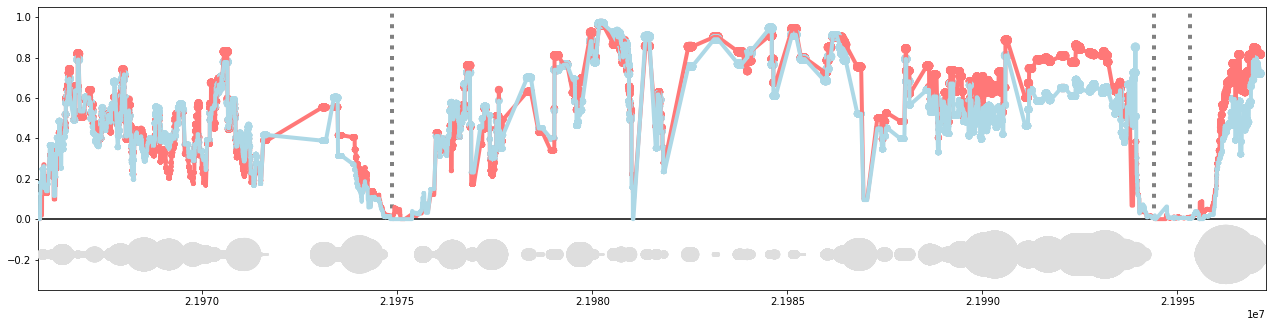

In [32]:
import matplotlib.pyplot as plt
plt.subplots(figsize=[22,5.2])
import numpy as np

sns.scatterplot((mC_sliding_nonpcr.sum()/tC_sliding_nonpcr.sum()).index,\
               (mC_sliding_nonpcr.sum()/tC_sliding_nonpcr.sum()).fillna(0),\
                s=(mC_sliding_nonpcr.sum()/tC_sliding_nonpcr.sum()).fillna(0)*100,\
                color='#ff7878', zorder=7,)



sns.lineplot((mC_sliding_nonpcr.sum()/tC_sliding_nonpcr.sum()).dropna().index,\
               (mC_sliding_nonpcr.sum()/tC_sliding_nonpcr.sum()).dropna(),\
                color='#ff7878', linewidth=4,zorder=7,)
sns.scatterplot((mC_sliding_pcr.sum()/tC_sliding_pcr.sum()).fillna(0).index,\
               (mC_sliding_pcr.sum()/tC_sliding_pcr.sum()).fillna(0),\
             s=(mC_sliding_pcr.sum()/tC_sliding_pcr.sum()).fillna(0)*100,\
                color='lightblue',zorder=7,)
sns.lineplot((mC_sliding_pcr.sum()/tC_sliding_pcr.sum()).dropna().index,\
               (mC_sliding_pcr.sum()/tC_sliding_pcr.sum()).dropna(),\
                color='lightblue', linewidth=4,zorder=7,)


muC_p = pd.DataFrame(mC_sliding_pcr_sum)
muC_p[0] = muC_p.index.map(pval)
muC_p[0] = (-1* muC_p[0].apply(np.log10).fillna(0))+10


sns.scatterplot(mC_sliding_pcr_sum.index,[-0.175 for i in mC_sliding_pcr_sum.index],\
               s = -1000+(100*muC_p[0]),\
                color='#dedede',zorder=7)

plt.plot([21994392,21994392],[-0.,1.1],color='gray', linewidth=4, linestyle=":")
plt.plot([21995324,21995324],[-0.,1.1],color='gray', linewidth=4, linestyle=":")
plt.plot([21974857,21974857],[-0.,1.1],color='gray', linewidth=4, linestyle=":")

plt.plot([mC_sliding_pcr.sum().index.min(),mC_sliding_pcr.sum().index.max()],[0,0], color='#000000')
plt.xlim([mC_sliding_pcr.sum().index.min(),mC_sliding_pcr.sum().index.max()])
plt.ylim(-0.35,1.05)
plt.savefig('../figures/cdkn2a_details.pdf')